In [2]:
import os
import math
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

from tqdm.auto import tqdm

/tmp/ipython-input-4121191643.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


In [3]:
import jax
import jax.numpy as jnp
print(jax.__version__)

0.7.2


In [4]:
a = jnp.zeros((2,5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [5]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


In [6]:
b.__class__

jaxlib._jax.ArrayImpl

In [7]:
b.device

CudaDevice(id=0)

In [8]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


In [9]:
# to push numpy array to an accelerator use jax.device_put()
b_gpu = jax.device_put(b_cpu)
print(f"device put: {b_gpu.__class__} on {b_gpu.device}")

device put: <class 'jaxlib._jax.ArrayImpl'> on cuda:0


In [10]:
b_cpu + b_gpu # jax handles device clashes on its own

Array([ 0,  2,  4,  6,  8, 10], dtype=int32)

In [11]:
jax.devices()

[CudaDevice(id=0)]

In [12]:
b_new = b.at[0].set(3)
print('Original array: ', b)
print('New array: ', b_new)

Original array:  [0 1 2 3 4 5]
New array:  [3 1 2 3 4 5]


In [13]:
# PRNG - pseudo random number generation
rng = jax.random.PRNGKey(42) # random numbe generation is deterministic

In [14]:
# a non desireable way of generating random numbers
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)

print(f"jax - randon number 1: {jax_random_number_1}")
print(f"jax - randon number 2: {jax_random_number_2}")

# typical random numbers in pytorch
np.random.seed(2)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print(f"numpy - randon number 1: {np_random_number_1}")
print(f"numpy - randon number 2: {np_random_number_2}")

jax - randon number 1: -0.02830461598932743
jax - randon number 2: -0.02830461598932743
numpy - randon number 1: -0.4167578474054706
numpy - randon number 2: -0.056266827226329474


In [15]:
# subkeys for everytime you need a pseudo random number
rng, subkey1, subkey2 = jax.random.split(rng, num=3) # 3 new keys
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print(f"jax - randon number 1: {jax_random_number_1}")
print(f"jax - randon number 2: {jax_random_number_2}")


jax - randon number 1: 0.6057640314102173
jax - randon number 2: 0.4323064982891083


In [16]:
# comapring jaxpr of funtion with and without side effects
# jaxpr - jax expressions; how jax represents math operations in python code
def simple_graph(x):
    x = x + 2
    x = x ** 2
    x = x + 3
    y = x.mean()
    return y

inp = jnp.arange(3, dtype=jnp.float32)
print('input: ', inp)
print('ouput: ', simple_graph(inp))

input:  [0. 1. 2.]
ouput:  12.666667


In [17]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0:f32[]
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0:f32[]
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0:f32[]
  in (f,) }

In [18]:
global_list = []

# Invalid function with side-effect
def norm(x):
    global_list.append(x)
    x = x ** 2
    n = x.sum()
    n = jnp.sqrt(n)
    return n

jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

In [19]:
## Automatic differentiation

In [20]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print(gradients)

[1.3333334 2.        2.6666667]


In [21]:
# print jax expression of resulting function
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0:f32[]
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0:f32[] d
    f:f32[3] = add c 3.0:f32[]
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0:f32[]
    h:f32[] = div 1.0:f32[] 3.0:f32[]
    i:f32[3] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(3,)
      sharding=None
    ] h
    j:f32[3] = mul i e
  in (j,) }

In [22]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

In [23]:
# pytrees are a way jax organizes its data structure to summerize all parameters

In [24]:
# Just-in-time computation
# xla  -> accelerated linear algebra, xla fuses operations to reduce execution time of short lived operations and eliminates intermediate storage buffers where not needed

In [25]:
# jax uses jax.jit transformation to compile a function with xla
jitted_function = jax.jit(simple_graph)

In [26]:
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1000, ))

# run the jitted function once to start compilation
_ = jitted_function(large_input)

In [27]:
%%timeit
simple_graph(large_input).block_until_ready()

597 µs ± 37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%%timeit
jitted_function(large_input).block_until_ready()

The slowest run took 4.09 times longer than the fastest. This could mean that an intermediate result is being cached.
131 µs ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)

In [30]:
%%timeit
grad_function(large_input).block_until_ready()


5.05 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

88.4 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### implementing a neural network in flax

In [32]:
try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

from flax import linen as nn

In [33]:
class MyModule(nn.Module):
  # some dataclass attributes, like hidden dimension, number of layers, etc. of the form:
  # varname : vartype

  def setup(self):
    # flax uses lazy initialization this function is called once before you
    # call the model, or try to access attributes. In here, define your submodules etc.
    pass

  def __call__(self, x):
    # this method is the same as forward function in pytorch
    # function for performing the calculation of the module
    pass

In [34]:
## simple classifier

class SimpleClassifier(nn.Module):
  num_hidden : int # number of hidden neurons
  num_outputs : int # number of output neurons

  def setup(self):
    # create modules we need to build the network
    # nn.Dense is a linear layer
    self.linear1 = nn.Dense(features=self.num_hidden)
    self.linear2 = nn.Dense(features=self.num_outputs)

  def __call__(self, x):
    # perform the calculation of the model to determine the prediction
    x = self.linear1(x)
    x = nn.tanh(x)
    x = self.linear2(x)
    return x

In [35]:
# because we are using the same functions declared in setup in __call__,
# flax has an alternative to reduce code overhead
# @nn.compact gets rid of the setup function

In [64]:
class SimpleClassifierCompact(nn.Module):
  num_hidden : int
  num_outputs : int

  @nn.compact # this tells flax to look for defined submodules
  def __call__(self, x):
    x = nn.Dense(features=self.num_hidden)(x)
    x = nn.tanh(x)
    x = nn.Dense(features=self.num_outputs)(x)
    return x

In [65]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [66]:
# initialize parameters
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8,2)) # batch_size 8, input size 2
# initialize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'linear1': {'kernel': Array([[ 0.80862993, -0.21181293, -0.7687496 , -0.04200545,  0.49210244,
         0.01333587,  0.33707538, -0.22262472],
       [ 0.09671354,  0.58868766, -0.1583192 , -0.21863122,  1.4024782 ,
         0.95260483, -0.18002191,  0.37392944]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'linear2': {'kernel': Array([[-0.14248851],
       [ 0.05412908],
       [ 0.43876585],
       [-0.07800896],
       [-0.00524857],
       [ 0.03016142],
       [ 0.15866321],
       [-0.6494532 ]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


In [67]:
model.apply(params, inp)

Array([[-0.02443248],
       [-0.44649464],
       [ 0.31689823],
       [ 0.42837867],
       [ 0.68654263],
       [-0.4580575 ],
       [-0.0804556 ],
       [ 0.09876201]], dtype=float32)

In [68]:
import torch.utils.data as data

In [69]:
class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [70]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


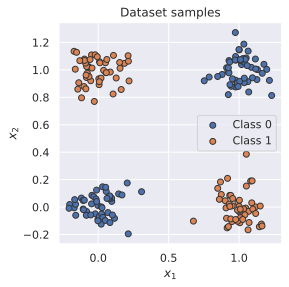

In [71]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

visualize_samples(dataset.data, dataset.label)
plt.show()

In [72]:
# in jax, out collate function should be in NumPy arrays

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
      return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)



In [73]:
data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 1.1266911   0.9292331 ]
 [ 0.9281556   0.9786553 ]
 [ 1.0504987   1.0865755 ]
 [ 1.0872321   1.0183342 ]
 [-0.20674421 -0.008912  ]
 [ 1.1644968   0.9750964 ]
 [-0.08254972 -0.03213858]
 [ 0.21221562  1.1032466 ]]
Data labels (8,) 
 [0 0 0 0 0 0 0 1]


In [74]:
## optimization
# optax is an optimization library for jax, it offers the most common deep learning optimizers(SGD, Adam, Adagrad, RMSProp) and utilities(gradient clipping, weigth decay etc.)


In [75]:
try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

In [76]:
optimizer = optax.sgd(learning_rate=0.1)

In [77]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [78]:
# loss function
# BCE loss

def calculate_loss_acc(state, params, batch):
  data_input, labels = batch
  # obtain logits and predictions of the model for the input data
  logits = state.apply_fn(params, data_input).squeeze(axis=-1)
  pred_labels = (logits > 0).astype(jnp.float32)

  # calculate the loss and accuracy
  loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
  acc = (pred_labels == labels).mean()
  return loss, acc

In [79]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.72375816, dtype=float32), Array(0.25, dtype=float32))

In [80]:
## TRAINING LOOP
@jax.jit
def train_step(state, batch):
  # gradient function
  grad_fn = jax.value_and_grad(calculate_loss_acc, # fn to calculate the loss
                               argnums=1, # params are the second (1) argument of the function
                               has_aux=True # fn has additional outputs, here acc
                               )
  # determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, batch)
  # perform parameter update for the current model, parameters and batch
  state = state.apply_gradients(grads=grads)
  # return state and any other value we might want
  return state, loss, acc

In [91]:
# for evaluation
@jax.jit
def eval_step(state, batch):
  # deterine the accuracy
  _, acc = calculate_loss_acc(state, state.params, batch)
  return acc

In [82]:
# train the model
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)


In [83]:
def train_model(state, data_loader, num_epochs):
  for epoch in range(num_epochs):
    for batch in data_loader:
      state, loss, acc = train_step(state, batch)

    print(f"{epoch+1}/{num_epochs} | loss: {loss:.4f} | acc: {acc:.4f}")

  return state

In [84]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

1/100 | loss: 0.6902 | acc: 0.5735
2/100 | loss: 0.6832 | acc: 0.6029
3/100 | loss: 0.6693 | acc: 0.6912
4/100 | loss: 0.6660 | acc: 0.7206
5/100 | loss: 0.6608 | acc: 0.7059
6/100 | loss: 0.6468 | acc: 0.7353
7/100 | loss: 0.6299 | acc: 0.7500
8/100 | loss: 0.6121 | acc: 0.7353
9/100 | loss: 0.5947 | acc: 0.7353
10/100 | loss: 0.5849 | acc: 0.7794
11/100 | loss: 0.5293 | acc: 0.9118
12/100 | loss: 0.5413 | acc: 0.8824
13/100 | loss: 0.5051 | acc: 0.9412
14/100 | loss: 0.4961 | acc: 0.8971
15/100 | loss: 0.4526 | acc: 1.0000
16/100 | loss: 0.4200 | acc: 1.0000
17/100 | loss: 0.3871 | acc: 1.0000
18/100 | loss: 0.3687 | acc: 1.0000
19/100 | loss: 0.3422 | acc: 1.0000
20/100 | loss: 0.2951 | acc: 1.0000
21/100 | loss: 0.3020 | acc: 1.0000
22/100 | loss: 0.2850 | acc: 1.0000
23/100 | loss: 0.2386 | acc: 1.0000
24/100 | loss: 0.2204 | acc: 1.0000
25/100 | loss: 0.2120 | acc: 1.0000
26/100 | loss: 0.2060 | acc: 1.0000
27/100 | loss: 0.1773 | acc: 1.0000
28/100 | loss: 0.1607 | acc: 1.0000
2

In [88]:
import os
from flax.training import checkpoints

checkpoints.save_checkpoint(ckpt_dir=os.path.abspath('my_checkpoints/'),  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

'/content/my_checkpoints/my_model100'

In [89]:
# to load state dict again use 'checkpoints.restore_checkpoint'
loaded_model_state = checkpoints.restore_checkpoint(
    ckpt_dir = os.path.abspath('my_checkpoints/'), # folder with checkpoints
    target=model_state, # (optional) matching object to rebuild state in
    prefix='my_model' # checkpoint file name prefix
)

In [90]:
## evaluation
test_dataset = XORDataset(size=500, seed=123)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, collate_fn=numpy_collate)


In [93]:
def eval_model(state, data_loader):
  all_accs, batch_sizes = [], []
  for batch in data_loader:
    batch_acc = eval_step(state, batch)
    all_accs.append(batch_acc)
    batch_sizes.append(batch[0].shape[0])
  # weighted average since some batches might be smaller
  acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
  print(f"accuracy of the model: {100.0 * acc:4.2f}%")

In [94]:
eval_model(trained_model_state, test_data_loader)

accuracy of the model: 100.00%


In [95]:
# instead of using model.apply(params=..., input), you can bind the instance model to our trained_parameter
trained_model = model.bind(trained_model_state.params)


In [96]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)
out.shape

(8, 1)

In [97]:
out

Array([[-5.1874585],
       [ 4.25992  ],
       [-4.2559423],
       [ 3.5071218],
       [-5.0442886],
       [-4.0917273],
       [-5.718045 ],
       [ 4.256082 ]], dtype=float32)

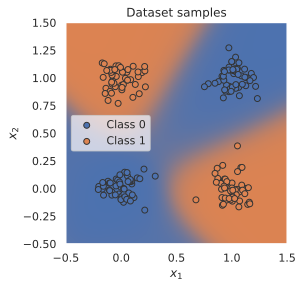

In [98]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()